In [37]:
# uv venv && source .venv/bin/activate
%pip install -q datasets transformers pytorch-lightning matplotlib seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [38]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

def load_hotpotqa_dataset():
    """
    Load the HotpotQA dataset from the Hugging Face datasets library.
    Returns the dataset object.
    """
    try:
        dataset = load_dataset("hotpot_qa", "distractor")
        print("Successfully loaded HotpotQA dataset!")
        return dataset
    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Please ensure you have the 'datasets' library installed.")
        return None

# Load the dataset
hotpotqa = load_hotpotqa_dataset()

Successfully loaded HotpotQA dataset!


In [39]:
def explore_dataset_structure(dataset):
    """
    Print basic information about the dataset structure.
    """
    if dataset is None:
        print("No dataset to explore.")
        return
    
    # Show available splits
    print(f"Dataset splits: {list(dataset.keys())}")
    
    # Show split sizes
    for split in dataset.keys():
        print(f"Size of {split} split: {len(dataset[split])}")
    
    # Look at column names (features)
    print(f"\nDataset features: {dataset['train'].features}")
    
    # Get a sample from the training set
    sample = dataset['train'][0]
    
    # Print out the structure of the sample
    print("\nSample structure:")
    for key in sample:
        value = sample[key]
        
        if isinstance(value, list):
            print(f"{key}: List with {len(value)} items")
            # If the list has elements, show the first one
            if len(value) > 0:
                if key == "context":
                    print(f"  First item: Title = '{value[0][0]}', with {len(value[0][1])} sentences")
                elif key == "supporting_facts":
                    print(f"  Format: [document_title, sentence_id]")
                    if len(value) > 0:
                        print(f"  First item: {value[0]}")
                else:
                    print(f"  First item type: {type(value[0])}")
        else:
            print(f"{key}: {type(value)}")
            if isinstance(value, str):
                if len(value) > 70:
                    print(f"  Value (truncated): {value[:70]}...")
                else:
                    print(f"  Value: {value}")
    
    return sample

# Explore the dataset structure
sample = explore_dataset_structure(hotpotqa)

Dataset splits: ['train', 'validation']
Size of train split: 90447
Size of validation split: 7405

Dataset features: {'id': Value(dtype='string', id=None), 'question': Value(dtype='string', id=None), 'answer': Value(dtype='string', id=None), 'type': Value(dtype='string', id=None), 'level': Value(dtype='string', id=None), 'supporting_facts': Sequence(feature={'title': Value(dtype='string', id=None), 'sent_id': Value(dtype='int32', id=None)}, length=-1, id=None), 'context': Sequence(feature={'title': Value(dtype='string', id=None), 'sentences': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}, length=-1, id=None)}

Sample structure:
id: <class 'str'>
  Value: 5a7a06935542990198eaf050
question: <class 'str'>
  Value: Which magazine was started first Arthur's Magazine or First for Women?
answer: <class 'str'>
  Value: Arthur's Magazine
type: <class 'str'>
  Value: comparison
level: <class 'str'>
  Value: medium
supporting_facts: <class 'dict'>
context: <class 'dict'>


Dataset splits analysis:

TRAIN split:
  Size: 90447 examples
  Yes/No questions: approximately 5.90%
  Question types:
    medium: 607 sampled examples (60.70%)
    hard: 179 sampled examples (17.90%)
    easy: 214 sampled examples (21.40%)

VALIDATION split:
  Size: 7405 examples
  Yes/No questions: approximately 5.90%
  Question types:
    hard: 1000 sampled examples (100.00%)


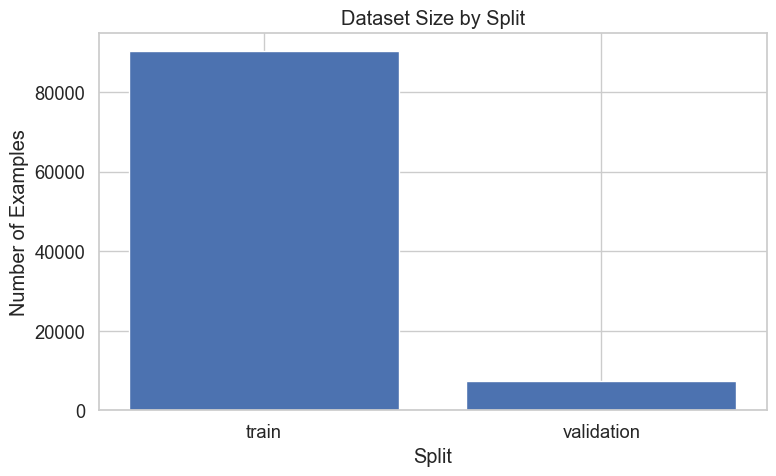

In [40]:
def examine_dataset_splits(dataset):
    """
    Analyze how the dataset is divided and what each split contains.
    """
    if dataset is None:
        print("No dataset to examine.")
        return
    
    # Get information about each split
    split_info = {}
    for split in dataset.keys():
        split_data = dataset[split]
        
        # Count question types (based on "level" field)
        question_types = {}
        for i in range(min(1000, len(split_data))):  # Sample the first 1000 examples
            example = split_data[i]
            q_type = example.get('level', 'Not specified')
            if q_type not in question_types:
                question_types[q_type] = 0
            question_types[q_type] += 1
        
        # Count yes/no questions
        yes_no_count = 0
        for i in range(min(1000, len(split_data))):  # Sample the first 1000 examples
            example = split_data[i]
            if example['answer'].lower() in ['yes', 'no']:
                yes_no_count += 1
        
        # Estimate percentage of yes/no questions
        if len(split_data) > 0:
            yes_no_percent = yes_no_count / min(1000, len(split_data)) * 100
        else:
            yes_no_percent = 0
        
        # Store information about the split
        split_info[split] = {
            'size': len(split_data),
            'question_types': question_types,
            'yes_no_question_percent': yes_no_percent,
        }
    
    # Display the information
    print("Dataset splits analysis:")
    for split, info in split_info.items():
        print(f"\n{split.upper()} split:")
        print(f"  Size: {info['size']} examples")
        print(f"  Yes/No questions: approximately {info['yes_no_question_percent']:.2f}%")
        
        if isinstance(info['question_types'], dict) and info['question_types']:
            print("  Question types:")
            for q_type, count in info['question_types'].items():
                percent = count/min(1000, info['size'])*100
                print(f"    {q_type}: {count} sampled examples ({percent:.2f}%)")
    
    # Plot the split sizes
    plt.figure(figsize=(8, 5))
    plt.bar(split_info.keys(), [info['size'] for info in split_info.values()])
    plt.title('Dataset Size by Split')
    plt.xlabel('Split')
    plt.ylabel('Number of Examples')
    plt.tight_layout()
    plt.show()
    
    return split_info

# Examine how the dataset is divided
split_info = examine_dataset_splits(hotpotqa)

In [41]:
def view_random_examples(dataset, split='train', n=3):
    """
    Display n random examples from the specified split.
    """
    if dataset is None:
        print("No dataset to view examples from.")
        return
    
    if split not in dataset:
        print(f"Split '{split}' not found in dataset.")
        return
    
    # Get random indices
    import random
    split_data = dataset[split]
    total_examples = len(split_data)
    random_indices = random.sample(range(total_examples), min(n, total_examples))
    
    # Display the random examples
    for i, idx in enumerate(random_indices):
        example = split_data[idx]
        
        print(f"\n=== Example {i+1} (index {idx}) ===")
        print(f"Question: {example['question']}")
        print(f"Answer: {example['answer']}")
        
        # Display supporting facts
        print("\nSupporting facts:")
        # First, check the data structure of supporting_facts
        supporting_facts = example['supporting_facts']
        
        # Print all supporting facts
        if isinstance(supporting_facts, list):
            for fact_idx, fact in enumerate(supporting_facts):
                print(f"  Fact {fact_idx+1}:")
                if isinstance(fact, dict):
                    # Handle dictionary format
                    title = fact.get('title', 'Unknown')
                    sent_id = fact.get('sent_id', 'Unknown')
                    print(f"    - Document: '{title}', Sentence: {sent_id}")
                elif isinstance(fact, list):
                    # Handle list format
                    if len(fact) >= 2:
                        title = fact[0]
                        sent_id = fact[1]
                        print(f"    - Document: '{title}', Sentence: {sent_id}")
                    else:
                        print(f"    - Unexpected format: {fact}")
                else:
                    print(f"    - Unexpected format: {fact}")
        else:
            print(f"  Unexpected format: {supporting_facts}")
        
        # Display context (limited to the first few sentences of each document)
        print("\nSample of context:")
        context = example['context']
        
        if isinstance(context, list):
            for doc_idx, doc in enumerate(context):
                if isinstance(doc, list) and len(doc) >= 2:
                    title = doc[0]
                    sentences = doc[1]
                    print(f"\nDocument {doc_idx+1}: '{title}'")
                    # Print the first 3 sentences of each document
                    for sent_idx, sentence in enumerate(sentences[:3]):
                        print(f"  Sentence {sent_idx}: {sentence}")
                    if len(sentences) > 3:
                        print(f"  ... ({len(sentences)-3} more sentences)")
                else:
                    print(f"\nDocument {doc_idx+1}: Unexpected format: {doc}")
        else:
            print(f"Unexpected context format: {context}")
        
        print("\n" + "="*50)
    
    return random_indices

# View random examples from the training set
random_indices = view_random_examples(hotpotqa, split='train', n=2)


=== Example 1 (index 18822) ===
Question: Which National Park in Spain is listed as an IUCN Category II National Park, Ordesa y Monte Perdido National Park or Picos de Europa National Park?
Answer: Ordesa y Monte Perdido National Park

Supporting facts:
  Unexpected format: {'title': ['Ordesa y Monte Perdido National Park', 'Picos de Europa National Park'], 'sent_id': [0, 0]}

Sample of context:
Unexpected context format: {'title': ['Ordesa y Monte Perdido National Park', 'Picos de Europa National Park', 'Lake Ercina', 'Monte Perdido', 'Lakes of Covadonga', 'Malkumba-Coongie Lakes National Park', 'List of national parks of Madagascar', 'Ordesa Valley', 'Lake Enol', 'Naranjo de Bulnes'], 'sentences': [['Ordesa y Monte Perdido National Park (Parque nacional de Ordesa y Monte Perdido) is an IUCN Category II National Park situated in the Pyrenees of Huesca province, Aragon, Spain.', ' There has been a National Park in the Ordesa Valley since 1918.', ' Its protected area was enlarged in 19